In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

2024-06-01 17:21:31.968355: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 17:21:31.968875: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 17:21:31.975695: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 17:21:32.051384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 17:21:33.847769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
# Path to ./data/processed folder
path_data_processed = os.path.join(
    os.path.abspath('../'),
    'data',
    'processed'
)

# Load Data

In [3]:
df_stocks = pd.read_csv(
    os.path.join(
        path_data_processed,
        'stock_market_dataset.csv'
    ),
    index_col=0
)

df_stocks = df_stocks.pivot_table(
    values='Close',
    index='Date',
    columns='Stock'
).reset_index(drop=False)

In [4]:
df_agg = pd.read_csv(
    os.path.join(
        path_data_processed,
        'reddit_news_avg_score_per_label.csv'
    )
)

In [5]:
# df = df_stocks.merge(df_agg, on='Date', how='left')

# stocks = ['AAPL'] # , 'AMZN', 'GOOGL', 'MSFT', 'NVDA'
# for stock in stocks:
#     df[f'{stock}_target'] = df[stock].shift(1)

In [6]:
df = df_stocks[['Date', 'AAPL']]
df['AAPL_target'] = df['AAPL'].shift(1)

/tmp/ipykernel_265340/3850301189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AAPL_target'] = df['AAPL'].shift(1)


# Data Preparation

In [7]:
# Select features
data = df.drop('Date', axis=1)

## Train-Test Split

In [8]:
# Set train percentage
train_percentage = 0.95

# Compute lenght of train dataframe
train_len = int(len(data) * train_percentage)

In [9]:
# Create data_train and data_test:
df_train = data.iloc[:train_len]
df_test = data.iloc[train_len:]

In [10]:
data.columns

Index(['AAPL', 'AAPL_target'], dtype='object', name='Stock')

## Scaling
Transforming numerical features into a common smaller range

In [11]:
features = [
    'AAPL',
    # 'AMZN',
    # 'GOOGL',
    # 'MSFT',
    # 'NVDA',
    # 'negative',
    # 'neutral',
    # 'positive'
]

target = [
    'AAPL_target',
    # 'AMZN_target',
    # 'GOOGL_target',
    # 'MSFT_target',
    # 'NVDA_target'
]

target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features])
df_train[features] = features_scaler.transform(df_train[features])
df_test[features] = features_scaler.transform(df_test[features])

/tmp/ipykernel_265340/2487932018.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target] = target_scaler.transform(df_train[target])
/tmp/ipykernel_265340/2487932018.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target] = target_scaler.transform(df_test[target])
/tmp/ipykernel_265340/2487932018.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

## Subsequences

In [12]:
# Create subsequence with 5 business days X 4 weeks X 3 months
length = 5 * 4 * 3
horizon = 1
window = 1

### One Subsequence

In [13]:
def subsequence(df, length, features, target):
    X, y = [], []

    for i in range(length, df.shape[0]):
        X.append(df[features].iloc[i - length: i]) #  + target
        y.append(df[target].iloc[i])

    return np.array(X), np.array(y)

In [14]:
X_train, y_train = subsequence(df_train, length, features, target)

X_test, y_test = subsequence(df_test, length, features, target)

In [15]:
df_test

Stock,AAPL,AAPL_target
1930,0.703613,0.695379
1931,0.703441,0.703613
1932,0.697466,0.703441
1933,0.692726,0.697466
1934,0.695130,0.692726
...,...,...
2027,0.683583,0.694959
2028,0.696547,0.683583
2029,0.703321,0.696547
2030,0.713349,0.703321


In [16]:
X_train.shape

(1870, 60, 1)

# RNN Model

In [17]:
# Padding train and test
X_train_pad = pad_sequences(X_train, value=-999, padding='post', dtype='float64')
X_test_pad = pad_sequences(X_test, value=-999, padding='post', dtype='float64')

In [18]:
# Build the model
def rnn_model():
    model = Sequential()

    model.add(layers.Masking(mask_value=-999))

    model.add(
        layers.LSTM(
            units=128,
            return_sequences = True,
            activation = "tanh",
            input_shape = X_train_pad[0].shape
        )
    )

    model.add(
        layers.LSTM(
            units=64,
            return_sequences = False,
            activation = "tanh"
        )
    )

    model.add(layers.Dense(25, activation="relu"))

    model.add(layers.Dense(1, activation="relu"))

    my_mae = metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)

    model.compile(
        loss="mse",
        optimizer = "rmsprop",
        metrics = [my_mae]
    )

    return model

model = rnn_model()

/home/nathalia/.pyenv/versions/3.10.6/envs/stocks_vs_behavior/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
%%time

es = EarlyStopping(patience = 25, monitor = "val_mean_absolute_error")

history = model.fit(
    X_train_pad,
    np.array(y_train),
    validation_split = 0.3,
    batch_size=16,
    epochs=300,
    verbose = 1,
    callbacks = [es]
)

Epoch 1/300


2024-06-01 17:21:42.265932: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - loss: 0.0130 - mean_absolute_error: 0.0743 - val_loss: 0.0019 - val_mean_absolute_error: 0.0349
Epoch 2/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.0014 - mean_absolute_error: 0.0286 - val_loss: 0.0124 - val_mean_absolute_error: 0.1019
Epoch 3/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.0011 - mean_absolute_error: 0.0232 - val_loss: 0.0016 - val_mean_absolute_error: 0.0337
Epoch 4/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.0010 - mean_absolute_error: 0.0243 - val_loss: 0.0019 - val_mean_absolute_error: 0.0342
Epoch 5/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 7.2518e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0067 - val_mean_absolute_error: 0.0739
Epoch 6/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 6.5011e-04 - mean_absolute_error: 0.0199 - val_loss: 8.4487e-04 - val_mean_absolute_error: 0.0240
Epoch 7/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 6.0374e-04 - mean_absolute

In [20]:
for i in history.history.keys():
    value = np.mean(history.history[i])
    print(i, " = ", value)

loss  =  0.0001565493214524249
mean_absolute_error  =  0.008292129988298763
val_loss  =  0.00052437393618222
val_mean_absolute_error  =  0.015645371773574925


In [21]:
def plot_loss_mae(history):

    fig, ax =plt.subplots(1,2,figsize=(20,5))

    # --- LOSS

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- MAE

    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    plt.show()

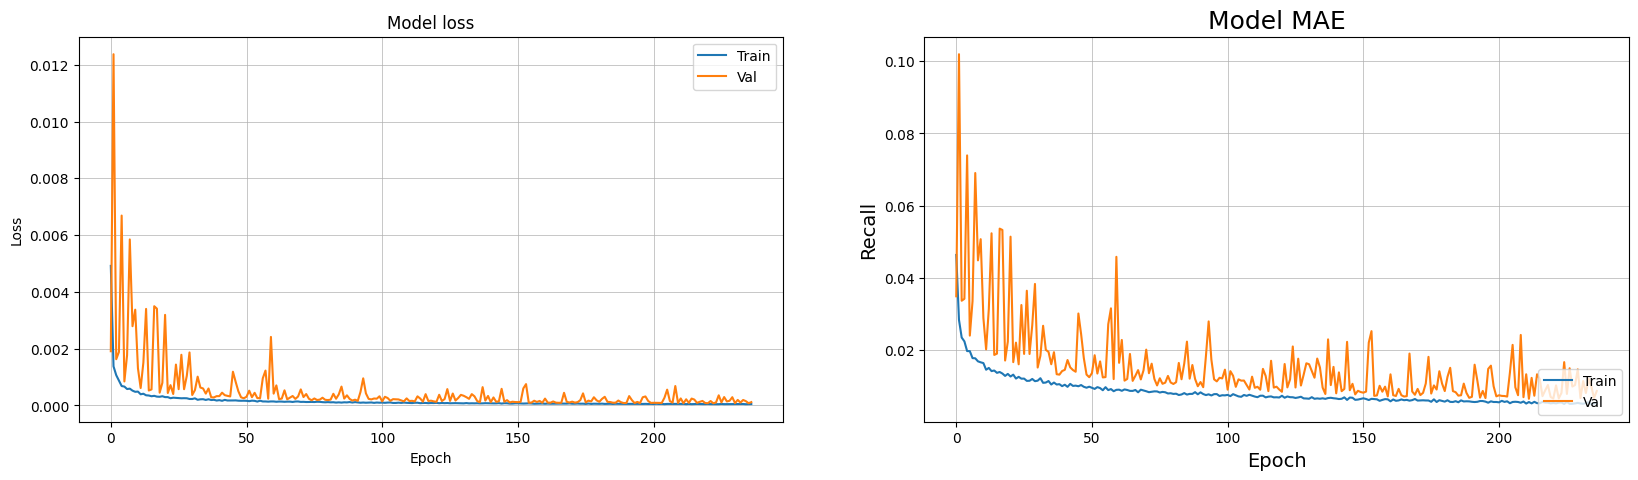

In [22]:
plot_loss_mae(history)

In [23]:
X_test

array([[[0.70361276],
        [0.70344105],
        [0.69746557],
        ...,
        [0.69306123],
        [0.69221986],
        [0.70502078]],

       [[0.70344105],
        [0.69746557],
        [0.6927264 ],
        ...,
        [0.69221986],
        [0.70502078],
        [0.69679591]],

       [[0.69746557],
        [0.6927264 ],
        [0.69513033],
        ...,
        [0.70502078],
        [0.69679591],
        [0.69361929]],

       ...,

       [[0.82665957],
        [0.83618943],
        [0.8160136 ],
        ...,
        [0.69495862],
        [0.68358288],
        [0.69654693]],

       [[0.83618943],
        [0.8160136 ],
        [0.81704385],
        ...,
        [0.68358288],
        [0.69654693],
        [0.70332086]],

       [[0.8160136 ],
        [0.81704385],
        [0.82004877],
        ...,
        [0.69654693],
        [0.70332086],
        [0.71334867]]])

In [29]:
y_pred = target_scaler.inverse_transform(model.predict(X_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [30]:
len(y_pred)

42

In [33]:
tmp = df_test.copy()
tmp['target'] = target_scaler.inverse_transform(tmp[['AAPL_target']])

In [38]:
X_test.shape

(42, 60, 1)

In [36]:
tmp['pred'] = y_pred

ValueError: Length of values (42) does not match length of index (102)

In [35]:
y_pred

array([[89.77227 ],
       [90.064995],
       [90.15454 ],
       [89.98294 ],
       [89.889145],
       [90.16008 ],
       [89.985565],
       [88.79854 ],
       [87.969536],
       [89.09305 ],
       [89.99451 ],
       [90.98683 ],
       [91.40065 ],
       [91.95418 ],
       [92.80905 ],
       [93.996605],
       [95.48552 ],
       [96.72894 ],
       [97.309265],
       [97.20948 ],
       [96.296715],
       [95.20346 ],
       [94.59071 ],
       [94.66394 ],
       [95.0614  ],
       [95.35423 ],
       [95.8489  ],
       [95.81666 ],
       [95.00527 ],
       [94.41806 ],
       [93.97435 ],
       [93.95143 ],
       [93.03951 ],
       [92.24909 ],
       [92.203674],
       [92.2079  ],
       [92.507286],
       [91.53621 ],
       [90.103905],
       [89.88869 ],
       [90.413864],
       [91.46863 ]], dtype=float32)

In [41]:
y_real = target_scaler.inverse_transform(y_test)

In [42]:
y_real - y_pred

array([[ 2.3597298 ],
       [ 1.10900519],
       [ 0.64945898],
       [ 0.31305933],
       [ 0.4768551 ],
       [ 0.81892004],
       [ 0.10743481],
       [-0.81953821],
       [ 0.18446417],
       [ 2.3339519 ],
       [ 1.05249316],
       [ 1.10316833],
       [ 0.33634998],
       [ 0.77782214],
       [ 1.09994849],
       [ 1.34539508],
       [ 1.51248059],
       [ 1.05805713],
       [ 0.41973486],
       [ 0.04151971],
       [-0.41071478],
       [-0.03646069],
       [ 0.7702865 ],
       [ 1.39005957],
       [ 1.38059863],
       [ 0.99976721],
       [ 1.19710016],
       [ 0.44134198],
       [-0.20927191],
       [ 0.4959397 ],
       [ 0.62765002],
       [ 1.04856873],
       [-0.20051263],
       [ 0.3669079 ],
       [ 1.20032568],
       [ 0.855099  ],
       [ 1.08171393],
       [-0.57620911],
       [-0.46890472],
       [ 1.25631287],
       [ 1.52013586],
       [ 1.63337207]])

In [52]:
df_diff = pd.concat([
    pd.DataFrame(y_real, columns=['Real']),
    pd.DataFrame(y_pred, columns=['Pred'])
], axis=1
)

df_diff['Next_Real'] = df_diff['Real'].shift(-1)
df_diff['Next_Pred'] = df_diff['Pred'].shift(-1)

df_diff['Diff_real'] = df_diff['Real'] - df_diff['Next_Real']
df_diff['Diff_pred'] = df_diff['Pred'] - df_diff['Next_Pred']

In [53]:
df_diff

,Real,Pred,Next_Real,Next_Pred,Diff_real,Diff_pred
0,92.132,89.772270,91.174,90.064995,0.958,-0.292725
1,91.174,90.064995,90.804,90.154541,0.370,-0.089546
2,90.804,90.154541,90.296,89.982941,0.508,0.171600
3,90.296,89.982941,90.366,89.889145,-0.070,0.093796
4,90.366,89.889145,90.979,90.160080,-0.613,-0.270935
5,90.979,90.160080,90.093,89.985565,0.886,0.174515
6,90.093,89.985565,87.979,88.798538,2.114,1.187027
7,87.979,88.798538,88.154,87.969536,-0.175,0.829002
8,88.154,87.969536,91.427,89.093048,-3.273,-1.123512
9,91.427,89.093048,91.047,89.994507,0.380,-0.901459
